# Pip Install Libraries for Metric
Since internet must be turned off for submission, we pip install from my other notebook [here][1] where I downloaded the WHL files.

[1]: https://www.kaggle.com/code/cdeotte/pip-install-lifelines

In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d542dfe1e5c4109b08a65d6efb9e3216e3d5c1c77555b688bb37bcf377de71ec
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


# Load Train and Test

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata 
from metric import score
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error  
from sklearn.model_selection import KFold,StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)

Test shape: (3, 58)
Train shape: (28800, 60)


In [3]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

def create_nelson(data):
    data=data.copy()
    naf = NelsonAalenFitter(nelson_aalen_smoothing=0)
    naf.fit(durations=data['efs_time'], event_observed=data['efs'])
    return naf.cumulative_hazard_at_times(data['efs_time']).values*-1

In [4]:
RMV = ["ID","efs","efs_time","y","efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [5]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [6]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [7]:
FOLDS = 10
def create_stratified_folds(data, target,n_splits=10,random_state=42):
    data['fold'] = -1
    if (target!="race_group"):
        data['bins'] = pd.qcut(data[target], q=50, duplicates='drop',labels=False)
    else :
        data["bins"]=data["race_group"]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for fold, (_, val_idx) in enumerate(skf.split(data, data['bins'])):
        data.loc[val_idx, 'fold'] = fold
    
    data = data.drop(columns=['bins'])
    return data

In [8]:
import os
import joblib
def model_train(model,train,target,FEATURES,n_splits=10,random_state=42,strat_lab="race_group"):
    model_name = type(model).__name__.lower()
    print(f"Model : {model_name} Label : {target}",end=" ")
    train=create_stratified_folds(train,strat_lab,n_splits,random_state)
    oof = np.zeros(len(train))
    pred = np.zeros(len(test))
    for i in range(n_splits):
        x_train = train.loc[train.fold!=i,FEATURES].copy()
        y_train = train.loc[train.fold!=i,target]
        x_valid = train.loc[train.fold==i,FEATURES].copy()
        y_valid = train.loc[train.fold==i,target]
        x_test = test[FEATURES].copy()

        if ("xgb" in model_name):
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],  
                verbose=0 
            )
        elif ("cat" in model_name):
            model.fit(x_train,y_train,
                  eval_set=(x_valid, y_valid),
                  cat_features=CATS,
                  verbose=0)
        elif ("lgbm" in model_name):
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],  
            )
        os.makedirs("saved_models", exist_ok=True)
        model_path = f"saved_models/{model_name}_{target}_rs{random_state}_fold{i}_strat{strat_lab}"

        if "catboost" in model_name:
            model.save_model(f"{model_path}.cbm")
        else:
            joblib.dump(model, f"{model_path}.pkl")

        # INFER OOF
        oof[train.index[train.fold==i]] = (model.predict(x_valid))
        # INFER TEST
        pred+= (model.predict(x_test))
    y_true = train[["ID","efs","efs_time","race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = oof

    m = score(y_true.copy(), y_pred.copy(), "ID")
    mape = mean_absolute_percentage_error(train[target],oof)  
    
    print(f"Overall CV = {m:.3f} and mape = {mape:.3f}")
    return oof,pred,m

In [9]:
models = {
    "y_nel": [
        XGBRegressor(reg_lambda=2,max_depth=4,colsample_bytree=0.55,  subsample=0.8,  n_estimators=5000,  learning_rate=0.02,  
                     enable_categorical=True,min_child_weight=80,early_stopping_rounds=200,n_jobs=4
        ),
        CatBoostRegressor(reg_lambda=2,learning_rate=0.09, subsample=0.95, grow_policy="Lossguide", early_stopping_rounds=100),
        LGBMRegressor(reg_lambda=2,max_depth=4, colsample_bytree=0.3, subsample=0.9, n_estimators=5000, learning_rate=0.02, 
                      objective="regression", verbose=-1, early_stopping_rounds=300, enable_categorical=True, 
                      min_child_weight=80, n_jobs=4)
        
    ],
    "y": [
        XGBRegressor(reg_lambda=2,max_depth=4, colsample_bytree=0.55, subsample=0.8, n_estimators=5000, learning_rate=0.02, 
                     enable_categorical=True, min_child_weight=80, early_stopping_rounds=300, n_jobs=4),
        CatBoostRegressor(reg_lambda=2,learning_rate=0.095, subsample=0.9, early_stopping_rounds=100),
        LGBMRegressor(reg_lambda=2,max_depth=5, colsample_bytree=0.35, subsample=0.9, n_estimators=3000, learning_rate=0.02, 
                      objective="regression", verbose=-1, early_stopping_rounds=100, n_jobs=4),
    ],
    "efs_time2": [
        XGBRegressor(reg_lambda=2,colsample_bytree=0.5, subsample=0.9, n_estimators=3000, learning_rate=0.02, enable_categorical=True, 
                     min_child_weight=70, objective="survival:cox", eval_metric="cox-nloglik", n_jobs=4),
        CatBoostRegressor(reg_lambda=2,loss_function="Cox", iterations=500, learning_rate=0.15, subsample=0.9, use_best_model=False),
    ],
}


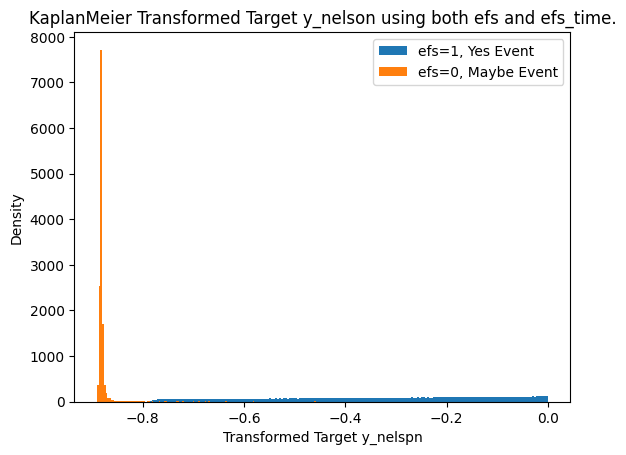

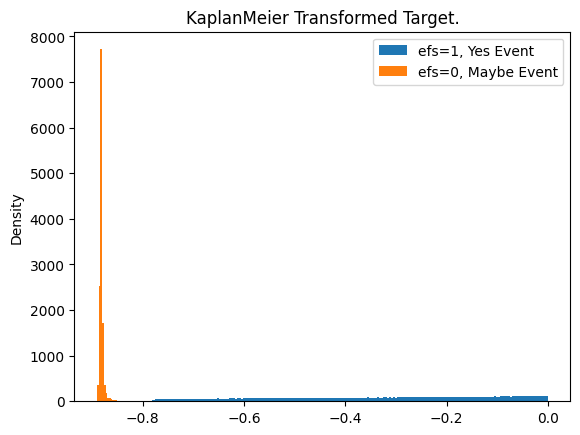

In [10]:
train["y_nel"] = create_nelson(train)
train.loc[train.efs == 0, "y_nel"] = (-(-train.loc[train.efs == 0, "y_nel"])**0.5)
plt.hist(train.loc[train.efs==1,"y_nel"],bins=200,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_nel"],bins=200,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_nelspn")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y_nelson using both efs and efs_time.")
plt.legend()
plt.show()

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train.efs == 0, "y"] = ((train.loc[train.efs == 0, "y"])**1.1)
plt.hist(train.loc[train.efs==1,"y_nel"],bins=200,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_nel"],bins=200,label="efs=0, Maybe Event")
# plt.xlabel("Transformed Target kaplan")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target.")
plt.legend()
plt.show()

train["efs_time2"] = train.efs_time.copy()
train.loc[:,"efs_time2"] **= 2
train.loc[train.efs==0,"efs_time2"] *= -1

In [11]:
train["y_nel"] = create_nelson(train)
train.loc[train.efs == 0, "y_nel"] = (-(-train.loc[train.efs == 0, "y_nel"])**0.5)

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train.efs == 0, "y"] = ((train.loc[train.efs == 0, "y"])**1.1)
all_oofs=[]
all_preds=[]
all_scores=[]
for label in ["y_nel","y","efs_time2"]:
    oof = np.zeros(len(train))
    pred = np.zeros(len(test))
    model_score=0
    for rs in [0,1,2,3,41,42,2025]:
        print("RS:" ,rs)
        for model in models[label]:   
            oof1,pred1,x=model_train(model,train,label,FEATURES,n_splits=10,random_state=rs,strat_lab="race_group")
            oof+=oof1
            pred+=pred1
            model_score+=x
            oof1,pred1,x=model_train(model,train,label,FEATURES,n_splits=10,random_state=20+rs,strat_lab="efs_time")
            oof+=oof1
            pred+=pred1
            model_score+=x

    print(oof)
    print(pred)
    all_oofs.append(oof)
    all_preds.append(pred)
    all_scores.append(model_score)


RS: 0
Model : xgbregressor Label : y_nel Overall CV = 0.679 and mape = 4.611
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.416
Model : catboostregressor Label : y_nel Overall CV = 0.676 and mape = 4.629
Model : catboostregressor Label : y_nel Overall CV = 0.678 and mape = 4.606
Model : lgbmregressor Label : y_nel Overall CV = 0.678 and mape = 4.619
Model : lgbmregressor Label : y_nel Overall CV = 0.678 and mape = 4.490
RS: 1
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.457
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.520
Model : catboostregressor Label : y_nel Overall CV = 0.676 and mape = 4.525
Model : catboostregressor Label : y_nel Overall CV = 0.678 and mape = 4.662
Model : lgbmregressor Label : y_nel Overall CV = 0.678 and mape = 4.506
Model : lgbmregressor Label : y_nel Overall CV = 0.680 and mape = 4.587
RS: 2
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.522
Model : xgbregressor Label : y_nel 

In [12]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] =sum(np.log1p(rankdata(all_oofs[i])*all_scores[i]) for i in range(len(all_oofs)))

m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

y_pred["prediction"] =sum((rankdata(all_oofs[i])*all_scores[i]) for i in range(len(all_oofs)))
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6829799365047259

Overall CV for Ensemble = 0.6827241676258264


# Create Submission CSV

In [13]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")

sub["prediction"] = sum(np.log1p(rankdata(all_preds[i])*all_scores[i]) for i in range(len(all_preds)))

sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")

sub["prediction"] = sum((rankdata(all_preds[i])*all_scores[i]) for i in range(len(all_preds)))

sub.to_csv("submission1.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)
Sub shape: (3, 2)


,ID,prediction
0,28800,151.472441
1,28801,227.208661
2,28802,75.736220
